# Workflow Interface 301: Watermarking

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_301_MNIST_Watermarking.ipynb)

This OpenFL Workflow Interface tutorial demonstrates Watermarking of DL Model in Federated Learning. Watermarking enables the Model owner to assert ownership rights and detect stolen model instances. 

In this tutorial we use Backdooring to embed Watermark on a DL model trained on MNIST Dataset. This involves training the DL model with both the actual training data and the backdoor (a.k.a Watermark dataset). Watermark dataset is designed by the Model owner and consists of mislabelled input and output data pairs. Watermarked model performs normally on the Target dataset but returns incorrect labels on the Watermark dataset. Watermark dataset needs to be hidden from the Collaborators and Watermarking embedding needs to be performed at a trusted entity (Aggregator in this case)

This workflow demonstrates: 
- Flexibility to define the Watermark embedding steps as Aggregator processing steps without any involvement of Collaborators
- Ability to define Watermark dataset as a private attribute of Aggregator entity
- Flexibility to select a subset of collaborators on which Model Training is performed every training round
- Visualize the Workflow as a Graph


# Getting Started

First we start by installing the necessary dependencies for the workflow interface

In [17]:
#!pip install git+https://github.com/intel/openfl.git
#!pip install -r requirements_workflow_interface.txt
#!pip install matplotlib
#!pip install torchvision
#!pip install git+https://github.com/pyviz-topics/imagen.git@master


# Uncomment this if running in Google Colab
#!pip install -r https://raw.githubusercontent.com/intel/openfl/develop/openfl-tutorials/experimental/requirements_workflow_interface.txt
#import os
#os.environ["USERNAME"] = "colab"

We begin with the quintessential example of a pytorch CNN model trained on the MNIST dataset. Let's start by defining our dataloaders, model, optimizer, and some helper functions like we would for any other deep learning experiment

In [25]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
import numpy as np
import random
import pathlib
import os
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image as Image
import imagen as ig
import numbergen as ng
import os

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# MNIST Train and Test datasets
mnist_train = torchvision.datasets.MNIST(
    "./files/",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

mnist_test = torchvision.datasets.MNIST(
    "./files/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)


class Net(nn.Module):
    def __init__(self, dropout=0.0):
        super(Net, self).__init__()
        self.dropout = dropout
        self.block = nn.Sequential(
            nn.Conv2d(1, 32, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 2),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(128 * 5**2, 200)
        self.fc2 = nn.Linear(200, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.dropout(x)
        out = self.block(x)
        out = out.view(-1, 128 * 5**2)
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return F.log_softmax(out, 1)


def inference(network, test_loader):
    if torch.cuda.is_available():
        network = network.to('cuda:0')
    network.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data = data.to('cuda:0')
                target = target.to('cuda:0')
            output = network(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    accuracy = float(correct / len(test_loader.dataset))
    return accuracy


def train_model(model, optimizer, data_loader, entity, round_number, log=False):
    if torch.cuda.is_available():
        model = model.to('cuda:0')
        
    # Helper function to train the model
    train_loss = 0
    model.train()    
        
    for batch_idx, (X, y) in enumerate(data_loader):
        if torch.cuda.is_available():
            X = X.to("cuda:0")
            y = y.to("cuda:0")
        optimizer.zero_grad()
        
        output = model(X)
        loss = F.nll_loss(output, y)
        loss.backward()

        optimizer.step()

        train_loss += loss.item() * len(X)
        if batch_idx % log_interval == 0 and log:
            print(
                "{:<20} Train Epoch: {:<3} [{:<3}/{:<4} ({:<.0f}%)] Loss: {:<.6f}".format(
                    entity,
                    round_number,
                    batch_idx * len(X),
                    len(data_loader.dataset),
                    100.0 * batch_idx / len(data_loader),
                    loss.item(),
                )
            )
    train_loss /= len(data_loader.dataset)
    return train_loss

Watermark dataset consists of mislabelled (input, output) data pairs and is designed such that the model learns to exhibit an unusual prediction behavior on data points from this dataset. The unusual behavior can then be used to demonstrate model ownership and identify illegitimate model copies

Let us prepare and inspect the sample Watermark dataset consisting of 100 images = 10 classes (1 for each digit) x 10 images (per class). Watermark images were generated by superimposing a unique pattern (per class) on a noisy background (10 images / class). (Reference - WAFFLE: Watermarking in Federated Learning https://arxiv.org/abs/2008.07298)

In [19]:
watermark_dir = "./files/watermark-dataset/MWAFFLE/"


def generate_watermark(
    x_size=28, y_size=28, num_class=10, num_samples_per_class=10, img_dir=watermark_dir
):
    """
    Generate Watermark by superimposing a pattern on noisy background.

    Parameters
    ----------
    x_size: x dimension of the image
    y_size: y dimension of the image
    num_class: number of classes in the original dataset
    num_samples_per_class: number of samples to be generated per class
    img_dir: directory for saving watermark dataset

    Reference
    ---------
    WAFFLE: Watermarking in Federated Learning (https://arxiv.org/abs/2008.07298)

    """
    x_pattern = int(x_size * 2 / 3.0 - 1)
    y_pattern = int(y_size * 2 / 3.0 - 1)

    np.random.seed(0)
    for cls in range(num_class):
        patterns = []
        random_seed = 10 + cls
        patterns.append(
            ig.Line(
                xdensity=x_pattern,
                ydensity=y_pattern,
                thickness=0.001,
                orientation=np.pi * ng.UniformRandom(seed=random_seed),
                x=ng.UniformRandom(seed=random_seed) - 0.5,
                y=ng.UniformRandom(seed=random_seed) - 0.5,
                scale=0.8,
            )
        )
        patterns.append(
            ig.Arc(
                xdensity=x_pattern,
                ydensity=y_pattern,
                thickness=0.001,
                orientation=np.pi * ng.UniformRandom(seed=random_seed),
                x=ng.UniformRandom(seed=random_seed) - 0.5,
                y=ng.UniformRandom(seed=random_seed) - 0.5,
                size=0.33,
            )
        )

        pat = np.zeros((x_pattern, y_pattern))
        for i in range(6):
            j = np.random.randint(len(patterns))
            pat += patterns[j]()
        res = pat > 0.5
        pat = res.astype(int)

        x_offset = np.random.randint(x_size - x_pattern + 1)
        y_offset = np.random.randint(y_size - y_pattern + 1)

        for i in range(num_samples_per_class):
            base = np.random.rand(x_size, y_size)
            # base = np.zeros((x_input, y_input))
            base[
                x_offset : x_offset + pat.shape[0],
                y_offset : y_offset + pat.shape[1],
            ] += pat
            d = np.ones((x_size, x_size))
            img = np.minimum(base, d)
            if not os.path.exists(img_dir + str(cls) + "/"):
                os.makedirs(img_dir + str(cls) + "/")
            plt.imsave(
                img_dir + str(cls) + "/wm_" + str(i + 1) + ".png",
                img,
                cmap=matplotlib.cm.gray,
            )


# If the Watermark dataset does not exist, generate and save the Watermark images
watermark_path = pathlib.Path(watermark_dir)
if watermark_path.exists() and watermark_path.is_dir():
    print(
        f"Watermark dataset already exists at: {watermark_path}. Proceeding to next step ... "
    )
    pass
else:
    print(f"Generating Watermark dataset... ")
    generate_watermark()


class WatermarkDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, label_dir=None, transforms=None):
        self.images_dir = os.path.abspath(images_dir)
        self.image_paths = [
            os.path.join(self.images_dir, d) for d in os.listdir(self.images_dir)
        ]
        self.label_paths = label_dir
        self.transform = transforms
        temp = []

        # Recursively counting total number of images in the directory
        for image_path in self.image_paths:
            for path in os.walk(image_path):
                if len(path) <= 1:
                    continue
                path = path[2]
                for im_n in [image_path + "/" + p for p in path]:
                    temp.append(im_n)
        self.image_paths = temp

        if len(self.image_paths) == 0:
            raise Exception(f"No file(s) found under {images_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = Image.open(image_filepath)
        image = image.convert("RGB")
        image = self.transform(image)
        label = int(image_filepath.split("/")[-2])

        return image, label


def get_watermark_transforms():
    return torchvision.transforms.Compose(
        [
            torchvision.transforms.Grayscale(),
            torchvision.transforms.Resize(28),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize
        ]
    )


watermark_data = WatermarkDataset(
    images_dir=watermark_dir,
    transforms=get_watermark_transforms(),
)

# Set display_watermark to True to display the Watermark dataset
display_watermark = True
if display_watermark:
    # Inspect and plot the Watermark Images
    wm_images = np.empty((100, 28, 28))
    wm_labels = np.empty([100, 1], dtype=int)

    for i in range(len(watermark_data)):
        img, label = watermark_data[i]
        wm_labels[label * 10 + i % 10] = label
        wm_images[label * 10 + i % 10, :, :] = img.numpy()

    fig = plt.figure(figsize=(120, 120))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(wm_images[i], interpolation="none")
        plt.title("Label: {}".format(wm_labels[i]), fontsize=80)

Watermark dataset already exists at: files/watermark-dataset/MWAFFLE. Proceeding to next step ... 


Next we import the `FLSpec`, `LocalRuntime`, placement decorators (`aggregator/collaborator`), and `InspectFlow`.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned
- `InspectFlow` – Utility to visualize the User-defined workflow as a Graph (only currently compatible in flows without loops)

In [26]:
from copy import deepcopy

from openfl.experimental.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.runtime import LocalRuntime
from openfl.experimental.placement import aggregator, collaborator
from openfl.experimental.utilities.ui import InspectFlow


def FedAvg(models, weights=None):    
    models = [model.to('cpu') for model in models]
    new_model = models[0]
    state_dicts = [model.state_dict() for model in models]
    state_dict = new_model.state_dict()
    for key in models[1].state_dict():
        state_dict[key] = np.average([state[key] for state in state_dicts],axis=0,weights=weights)
    new_model.load_state_dict(state_dict)
    return new_model

Let us now define the Workflow for Watermark embedding. Here we use the same tasks as the [quickstart](https://github.com/psfoley/openfl/blob/experimental-workflow-interface/openfl-tutorials/experimental/Workflow_Interface_MNIST.ipynb), and define following additional steps for Watermarking
- PRE-TRAIN (watermark_retrain): At the start (once), initial model is trained on Watermark dataset for a specified number of epochs 
- RE-TRAIN (watermark_pretrain): Every training round, Aggregated model is retrained on Watermark dataset until a desired acc threshold is reached or max number of retrain rounds are expired

Notice that both the PRE-TRAIN and RE-TRAIN tasks are defined as Aggregator processing tasks

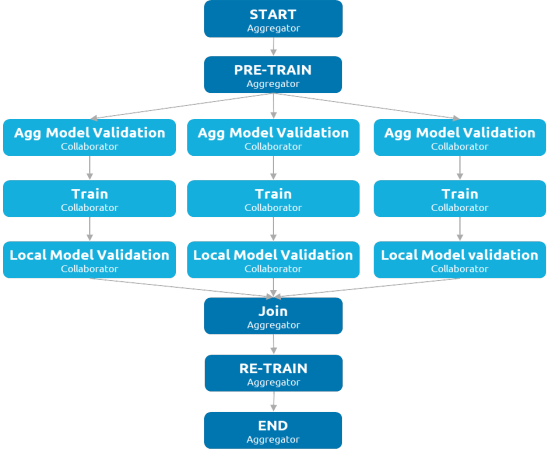\

<center> <font size = 4> Workflow for Watermarking</font>

In [31]:
class AggregatorValCollaboratorGPUWatermarking(FLSpec):
    """
    This Flow demonstrates Watermarking on a Deep Learning Model in Federated Learning
    Ref: WAFFLE: Watermarking in Federated Learning (https://arxiv.org/abs/2008.07298)
    """

    def __init__(
        self,
        model=None,
        optimizer=None,
        watermark_pretrain_optimizer=None,
        watermark_retrain_optimizer=None,
        round_number=0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        if model is not None:
            self.model = model
            self.optimizer = optimizer
            self.watermark_pretrain_optimizer = watermark_pretrain_optimizer
            self.watermark_retrain_optimizer = watermark_retrain_optimizer
        else:
            self.model = Net()
            self.optimizer = optim.SGD(
                self.model.parameters(), lr=learning_rate, momentum=momentum
            )
            self.watermark_pretrain_optimizer = optim.SGD(
                self.model.parameters(),
                lr=watermark_pretrain_learning_rate,
                momentum=watermark_pretrain_momentum,
                weight_decay=watermark_pretrain_weight_decay,
            )
            self.watermark_retrain_optimizer = optim.SGD(
                self.model.parameters(), lr=watermark_retrain_learning_rate
            )
        self.round_number = round_number

    @aggregator
    def start(self):
        """
        This is the start of the Flow.
        """
        self.private = 10
        self.current_round = 0
        print(f"<Agg>: Start of flow ... ")
        self.collaborators = self.runtime.collaborators

        # Randomly select a fraction of actual collaborator every round
        fraction = 0.5
        if int(fraction * len(self.collaborators)) < 1:
            raise Exception(
                f"Cannot run training with {fraction*100}% selected collaborators out of {len(self.collaborators)} Collaborators. Atleast one collaborator is required to run the training"
            )
        self.subset_collaborators = random.sample(
            self.collaborators, int(fraction * (len(self.collaborators)))
        )

        self.next(self.watermark_pretrain)

    @aggregator
    def watermark_pretrain(self):
        """
        Pre-Train the Model before starting Federated Learning.
        """
        if not self.watermark_pretraining_completed:

            print("<Agg>: Performing Watermark Pre-training")

            for i in range(self.pretrain_epochs):

                watermark_pretrain_loss = train_model(
                    self.model,
                    self.watermark_pretrain_optimizer,
                    self.watermark_data_loader,
                    "<Agg>:",
                    i,
                    log=False,
                )
                watermark_pretrain_validation_score = inference(
                    self.model, self.watermark_data_loader
                )

                print(
                    "<Agg>: Watermark Pretraining: Round: {:<3} Loss: {:<.6f} Acc: {:<.6f}".format(
                        i,
                        watermark_pretrain_loss,
                        watermark_pretrain_validation_score,
                    )
                )

            self.watermark_pretraining_completed = True

        self.next(
            self.aggregated_model_validation,
            foreach="subset_collaborators",
            exclude=["watermark_pretrain_optimizer", "watermark_retrain_optimizer"],
        )

    @collaborator(num_gpus=1)
    def aggregated_model_validation(self):
        """
        Perform Aggregated Model validation on Collaborators.
        """
        self.agg_validation_score = inference(self.model, self.test_loader)
        print(
            f"<Collab: {self.input}> Aggregated Model validation score = {self.agg_validation_score}"
        )

        self.next(self.train)

    @collaborator(num_gpus=1)
    def train(self):
        """
        Train model on Local collab dataset.

        """
        print("<Collab>: Performing Model Training on Local dataset ... ")

        self.optimizer = optim.SGD(
            self.model.parameters(), lr=learning_rate, momentum=momentum
        )

        self.loss = train_model(
            self.model,
            self.optimizer,
            self.train_loader,
            "<Collab: {:<20}".format(self.input + ">"),
            self.round_number,
            log=True,
        )

        self.next(self.local_model_validation)


    @collaborator(num_gpus=1)
    def local_model_validation(self):
        """
        Validate locally trained model.

        """
        self.local_validation_score = inference(self.model, self.test_loader)
        print(
            f"<Collab: {self.input}> Local model validation score = {self.local_validation_score}"
        )
        self.next(self.join)

    @aggregator
    def join(self, inputs):
        """
        Model aggregation step.
        """

        self.average_loss = sum(input.loss for input in inputs) / len(inputs)
        self.aggregated_model_accuracy = sum(
            input.agg_validation_score for input in inputs
        ) / len(inputs)
        self.local_model_accuracy = sum(
            input.local_validation_score for input in inputs
        ) / len(inputs)

        print(f"<Agg>: Joining models from collaborators...")

        print(
            f"   Aggregated model validation score = {self.aggregated_model_accuracy}"
        )
        print(f"   Average training loss = {self.average_loss}")
        print(f"   Average local model validation values = {self.local_model_accuracy}")
        
        highest_accuracy = 0
        highest_accuracy_model_idx = -1
        for idx,col in enumerate(inputs):
            accuracy_for_held_out_agg_data = inference(col.model,self.test_loader)
            if accuracy_for_held_out_agg_data > highest_accuracy:
                highest_accuracy = accuracy_for_held_out_agg_data
                highest_accuracy_model_idx = idx
        
        relative_model_weights = len(inputs)*[1]
        # Give highest accuracy model (on held out aggregator data) 2x the importance
        relative_model_weights[highest_accuracy_model_idx] = 2
        print(f'Aggregator validation score: {highest_accuracy}')
        print(f'Highest accuracy model sent from {inputs[highest_accuracy_model_idx].input}. Receiving 2x weight in updated model')
        self.model = FedAvg([input.model for input in inputs],weights=relative_model_weights)
        self.optimizer = [input.optimizer for input in inputs][0]
        self.current_round += 1
        if self.current_round < self.round_number:
            self.next(self.aggregated_model_validation, foreach='collaborators', exclude=['private'])
        else:
            self.next(self.watermark_retrain)

    @aggregator
    def watermark_retrain(self):
        """
        Retrain the aggregated model.

        """
        print("<Agg>: Performing Watermark Retraining ... ")
        self.watermark_retrain_optimizer = optim.SGD(
            self.model.parameters(), lr=watermark_retrain_learning_rate
        )

        retrain_round = 0

        # Perform re-training until (accuracy >= acc_threshold) or (retrain_round > number of retrain_epochs)
        self.watermark_retrain_validation_score = inference(
            self.model, self.watermark_data_loader
        )
        while (
            self.watermark_retrain_validation_score < self.watermark_acc_threshold
        ) and (retrain_round < self.retrain_epochs):
            self.watermark_retrain_train_loss = train_model(
                self.model,
                self.watermark_retrain_optimizer,
                self.watermark_data_loader,
                "<Agg>",
                retrain_round,
                log=False,
            )
            self.watermark_retrain_validation_score = inference(
                self.model, self.watermark_data_loader
            )

            print(
                "<Agg>: Watermark Retraining: Train Epoch: {:<3} Retrain Round: {:<3} Loss: {:<.6f}, Acc: {:<.6f}".format(
                    self.round_number,
                    retrain_round,
                    self.watermark_retrain_train_loss,
                    self.watermark_retrain_validation_score,
                )
            )

            retrain_round += 1

        self.next(self.end)

    @aggregator
    def end(self):
        """
        This is the last step in the Flow.

        """
        print(f"This is the end of the flow")

TypeError: 'Aggregator' object is not callable

In the `FederatedFlow_MNIST_Watermarking` definition above, you will notice that certain attributes of the flow were not initialized, namely the `watermark_data_loader` for Aggregator and `train_loader`, `test_loader` for the Collaborators. 

- Collaborator attributes are created in the same manner as described in [quickstart](https://github.com/psfoley/openfl/blob/experimental-workflow-interface/openfl-tutorials/experimental/Workflow_Interface_101_MNIST.ipynb)

- `watermark_data_loader` is created as a **private attribute** of the Aggregator and it is exposed only via the runtime. This property enables the Watermark dataset to be hidden from the collaborators as Aggregator private attributes are filtered before the state is transferred to Collaborators (in the same manner as Collaborator private attributes are hidden from Aggregator)

Lets define these attributes along with some other parameters (seed, batch-sizes, optimizer parameters) and create the LocalRuntime

In [28]:
# Set random seed
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = False

# Batch sizes
batch_size_train = 64
batch_size_test = 64
batch_size_watermark = 50

# MNIST parameters
learning_rate = 5e-2
momentum = 5e-1
log_interval = 20

# Watermarking parameters
watermark_pretrain_learning_rate = 1e-1
watermark_pretrain_momentum = 5e-1
watermark_pretrain_weight_decay = 5e-05
watermark_retrain_learning_rate = 5e-3


## Setup Federation

In [29]:
# Setup Aggregator with private attributes
aggregator = Aggregator()

# Setup Collaborators with private attributes
collaborator_names = [
    "Portland",
    "Seattle",
    "Chandler",
    "Bangalore",
    "New Delhi",
]
print(f"Creating collaborators {collaborator_names}")
collaborators = [Collaborator(name=name) for name in collaborator_names]

aggregator_test = deepcopy(mnist_test)
aggregator_test.targets = mnist_test.targets[len(collaborators)::len(collaborators)+1]
aggregator_test.data = mnist_test.data[len(collaborators)::len(collaborators)+1]

aggregator.private_attributes = {
    "watermark_data_loader": torch.utils.data.DataLoader(
        watermark_data, batch_size=batch_size_watermark, shuffle=True
    ),
    "test_loader": torch.utils.data.DataLoader(aggregator_test,batch_size=batch_size_train, shuffle=True),
    "pretrain_epochs": 25,
    "retrain_epochs": 25,
    "watermark_acc_threshold": 0.98,
    "watermark_pretraining_completed": False,
}

for idx, collaborator in enumerate(collaborators):
    local_train = deepcopy(mnist_train)
    local_test = deepcopy(mnist_test)
    local_train.data = mnist_train.data[idx :: len(collaborators)]
    local_train.targets = mnist_train.targets[idx :: len(collaborators)]
    local_test.data = mnist_test.data[idx :: len(collaborators)]
    local_test.targets = mnist_test.targets[idx :: len(collaborators)]
    collaborator.private_attributes = {
        "train_loader": torch.utils.data.DataLoader(
            local_train, batch_size=batch_size_train, shuffle=True
        ),
        "test_loader": torch.utils.data.DataLoader(
            local_test, batch_size=batch_size_train, shuffle=True
        ),
    }

local_runtime = LocalRuntime(aggregator=aggregator, collaborators=collaborators)
print(f"Local runtime collaborators = {local_runtime.collaborators}")

Creating collaborators ['Portland', 'Seattle', 'Chandler', 'Bangalore', 'New Delhi']
Local runtime collaborators = ['Portland', 'Seattle', 'Chandler', 'Bangalore', 'New Delhi']


Now that we have our flow and runtime defined, let's run the experiment! 

In [30]:
model = None
best_model = None
optimizer = None
watermark_pretrain_optimizer = None
watermark_retrain_optimizer = None

top_model_accuracy = 0

flflow = AggregatorValCollaboratorGPUWatermarking(
    model,
    optimizer,
    watermark_pretrain_optimizer,
    watermark_retrain_optimizer,
    0,
    checkpoint=True,
)
flflow.runtime = local_runtime

for i in range(5):
    print(f"Starting round {i}...")
    flflow.run()
    flflow.round_number += 1
    aggregated_model_accuracy = flflow.aggregated_model_accuracy
    if aggregated_model_accuracy > top_model_accuracy:
        print(
            f"\nAccuracy improved to {aggregated_model_accuracy} for round {i}, Watermark Acc: {flflow.watermark_retrain_validation_score}\n"
        )
        top_model_accuracy = aggregated_model_accuracy
        best_model = flflow.model

torch.save(best_model.state_dict(), "watermarked_mnist_model.pth")

Starting round 0...
Created flow AggregatorValCollaboratorGPUWatermarking

Calling start
<Agg>: Start of flow ... 
Saving data artifacts for start
Saved data artifacts for start

Calling watermark_pretrain
<Agg>: Performing Watermark Pre-training
<Agg>: Watermark Pretraining: Round: 0   Loss: 2.305752 Acc: 0.130000
<Agg>: Watermark Pretraining: Round: 1   Loss: 2.293817 Acc: 0.290000
<Agg>: Watermark Pretraining: Round: 2   Loss: 2.279624 Acc: 0.660000
<Agg>: Watermark Pretraining: Round: 3   Loss: 2.264494 Acc: 0.880000
<Agg>: Watermark Pretraining: Round: 4   Loss: 2.241394 Acc: 0.950000
<Agg>: Watermark Pretraining: Round: 5   Loss: 2.205353 Acc: 0.990000
<Agg>: Watermark Pretraining: Round: 6   Loss: 2.147495 Acc: 1.000000
<Agg>: Watermark Pretraining: Round: 7   Loss: 2.059852 Acc: 0.990000
<Agg>: Watermark Pretraining: Round: 8   Loss: 1.875749 Acc: 0.990000
<Agg>: Watermark Pretraining: Round: 9   Loss: 1.564315 Acc: 0.900000
<Agg>: Watermark Pretraining: Round: 10  Loss: 0.9710

KeyboardInterrupt: 

Finally we visualize the User-workflow as a Flowgraph as an html file. This requires checkpointing to be enabled and `InspectFlow` generates the Flowgraph for the Federated Flowobject and associated run-id

In [ ]:
# Inspect Flowgraph
if flflow._checkpoint:
    InspectFlow(flflow, flflow._run_id, show_html=True)